In [10]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.ai.vision.imageanalysis.models import VisualFeatures

from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = "c0e3fad3132645dea234a84aa708ef76"
endpoint = "https://dede.cognitiveservices.azure.com/"
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [11]:
##############################
# PROBLEMA 1 #################
##############################

def getResultFrame(imagePath):
    result_frame = [0,0,0,0]
    img = open(imagePath, "rb")
    result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
    for ob in result.objects:
        if ob.object_property == "bicycle":
            result_frame = [ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h]
    return result_frame

In [12]:
groundTruth = {
    'pozelab4/bike1.jpg': [3, 30, 410, 410],
    'pozelab4/bike02.jpg': [14, 85, 381, 323],
    'pozelab4/bike03.jpg': [60, 138, 346, 410],
    'pozelab4/bike04.jpg': [0, 0, 416, 415],
    'pozelab4/bike05.jpg': [67, 50, 357, 346],
    'pozelab4/bike06.jpg': [60, 140, 346, 407],
    'pozelab4/bike07.jpg': [54, 200, 300, 416],
    'pozelab4/bike08.jpg': [53, 0, 389, 354],
    'pozelab4/bike09.jpg': [2, 5, 381, 408],
    'pozelab4/bike10.jpg': [140, 129, 376, 407],
    'pozelab4/traffic01.jpg': [0, 0, 0, 0],
    'pozelab4/traffic02.jpg': [0, 0, 0, 0],
    'pozelab4/traffic03.jpg': [0, 0, 0, 0],
    'pozelab4/traffic04.jpg': [0, 0, 0, 0],
    'pozelab4/traffic05.jpg': [0, 0, 0, 0],
    'pozelab4/traffic06.jpg': [0, 0, 0, 0],
    'pozelab4/traffic07.jpg': [0, 0, 0, 0],
    'pozelab4/traffic08.jpg': [0, 0, 0, 0],
    'pozelab4/traffic09.jpg': [0, 0, 0, 0],
    'pozelab4/traffic10.jpg': [0, 0, 0, 0]
}


TP = 0
TN = 0
FP = 0
FN = 0

for imagePath in groundTruth:
    resultFrame = getResultFrame(imagePath)
    if groundTruth[imagePath] == [0,0,0,0]:
        if resultFrame == [0,0,0,0]:
            TN += 1
        else:
            FP += 1
    else:
        if resultFrame == [0,0,0,0]:
            FN += 1
        else:
            TP += 1
        
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
            
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\n")

Accuracy: 0.9
Precision: 1.0
Recall: 0.8



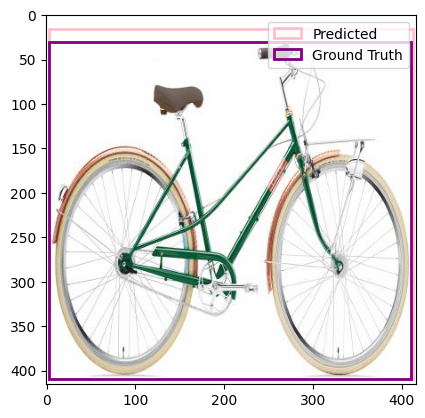

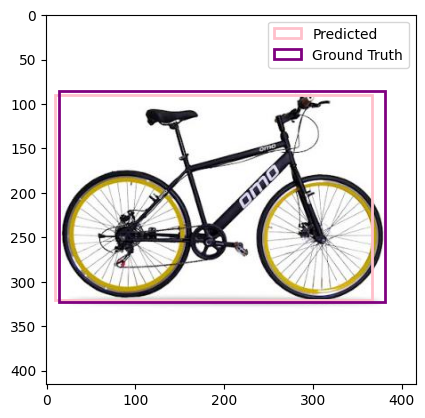

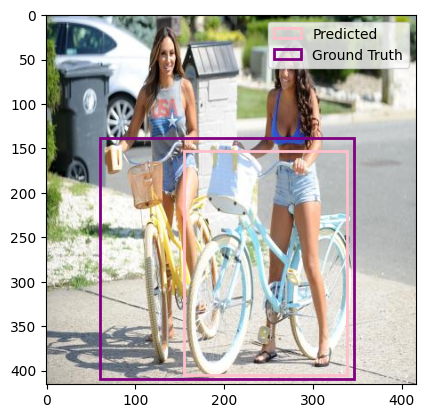

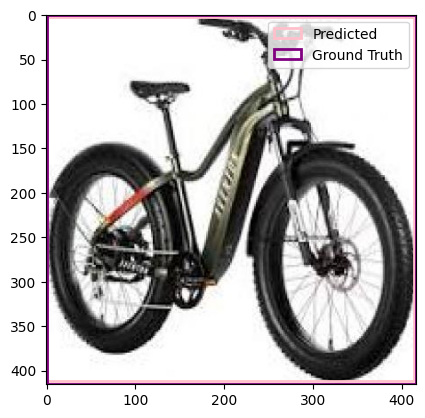

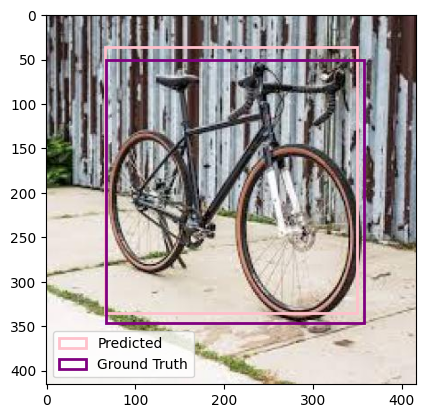

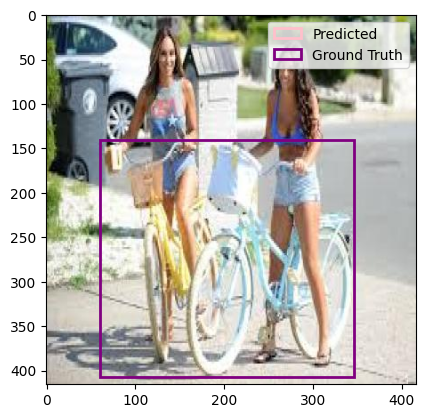

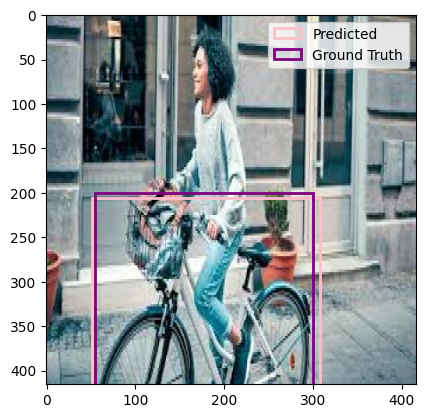

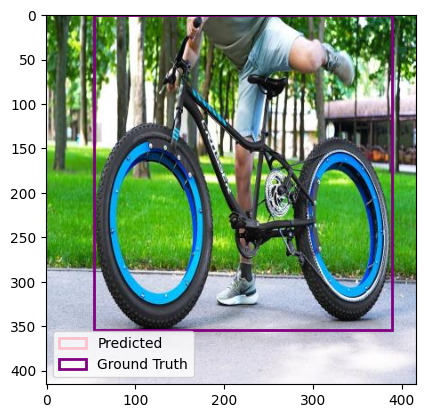

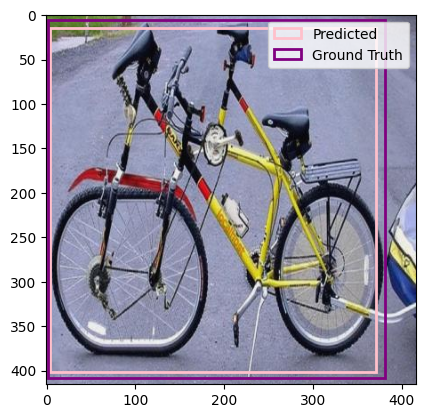

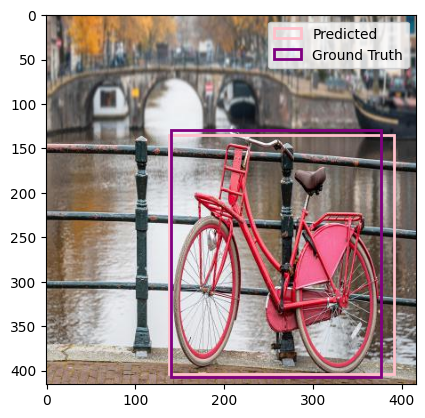

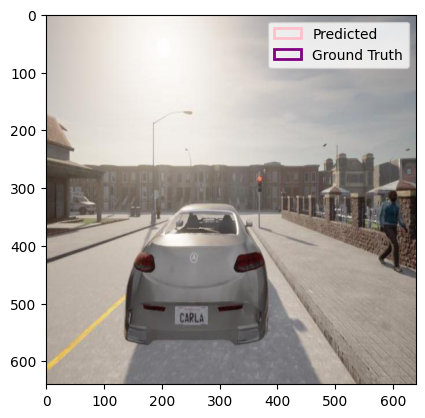

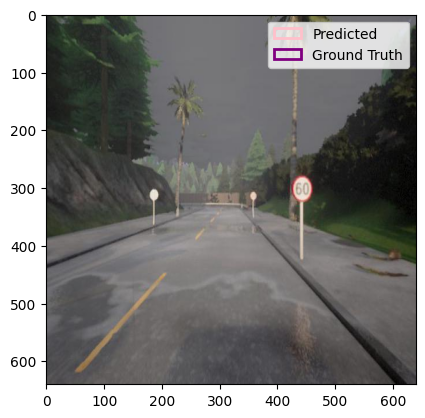

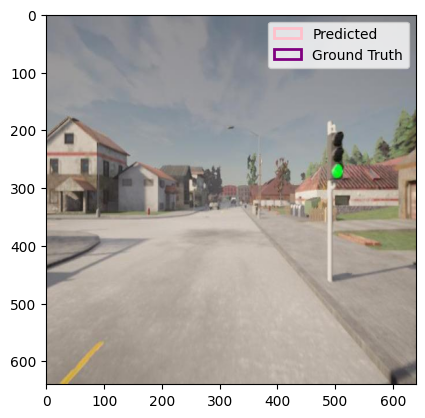

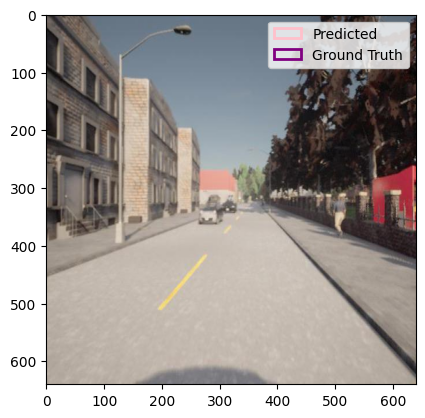

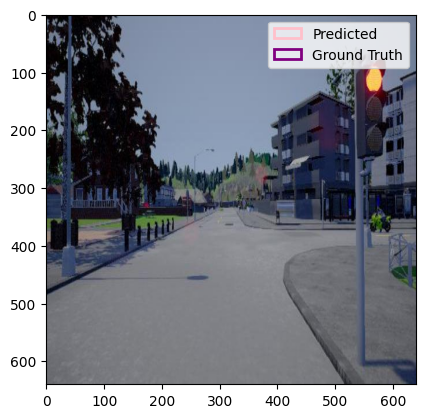

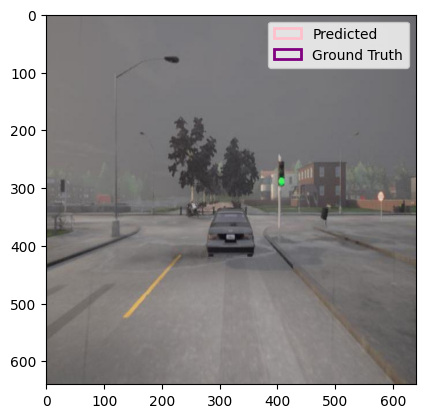

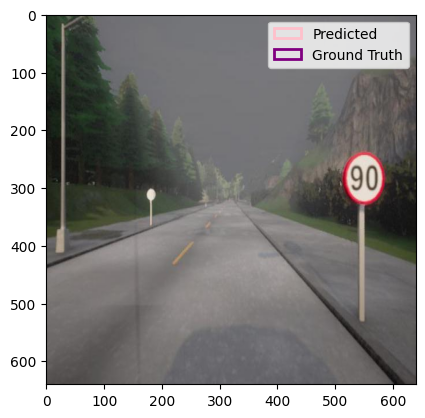

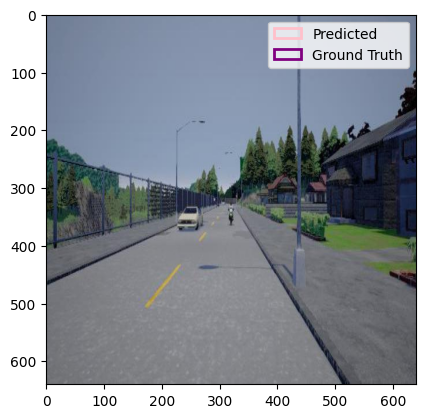

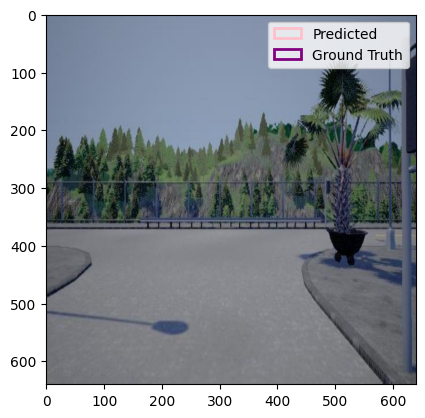

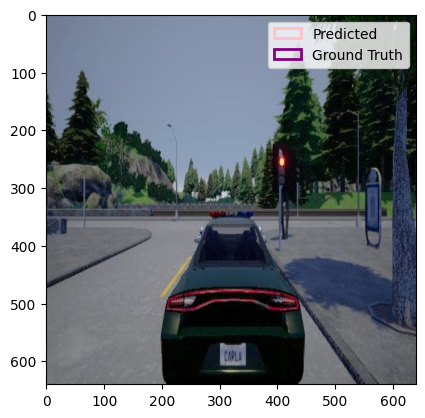

In [13]:
for imagePath in groundTruth: 
    frame = getResultFrame(imagePath)
    groundTruthFrame = groundTruth[imagePath]
    fig, axes = plt.subplots()
    im = Image.open(imagePath)
    fig = plt.imshow(im)
    axes.add_patch(plt.Rectangle(xy=(frame[0],frame[1]),width=frame[2]-frame[0],height=frame[3]-frame[1], fill=0, linewidth=2, edgecolor='pink'))
    axes.add_patch(plt.Rectangle(xy=(groundTruthFrame[0], groundTruthFrame[1]),width=groundTruthFrame[2]-groundTruthFrame[0], height=groundTruthFrame[3]-groundTruthFrame[1],fill=0, linewidth=2, edgecolor='purple'))
    plt.legend(["Predicted", "Ground Truth"])  # Adding legend
    
plt.show()

In [14]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou


TP = 0
TN = 0
FP = 0
FN = 0
treshold = 0.7

for imagePath in groundTruth:
    groundTruthFrame = groundTruth[imagePath]
    resultFrame = getResultFrame(imagePath)
    
    iou = bb_intersection_over_union(groundTruthFrame, resultFrame)
    # print(imagePath, iou)
    if groundTruthFrame == [0,0,0,0]:
        if iou > treshold:
            FP += 1
        else:
            TN += 1
    else:
        if iou > treshold:
            TP += 1
        else:
            FN += 1
            
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\n")

Accuracy: 0.35
Precision: 0.4117647058823529
Recall: 0.7

